# **example.ipynb**
---
- **概要**
    - S&P500の株価データと、S&P500ツイッター・センチメント指数から未来のS&P500の株価データを予測し、精度を評価する
    - S&P500の株価データのみで学習させたパターン、S&P500の株価データとS&P500ツイッター・センチメント指数で学習させたパターンで精度を比較する

# **0. ライブラリーインポート**
---
- **解説**
    - 今回の予測分析に必要なライブラリーをインポートする。
    - 数値的処理・分析において**pandas**, **numpy**, **matplotlib**, **sklearn**を使用する。
    - 時系列予測モデルの構築、学習において**tensorflow**を使用する。

In [1]:
# ライブラリーインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

2023-08-06 16:13:06.873885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 16:13:07.044096: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-06 16:13:07.615074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-06 16:13:07.615155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

# **1. データの読み込みと前処理**
---
- **解説**
    - 本研究で用いるデータの読み込みとモデルに組み込むための前処理を実施する。

## 1.1. データの読み込み
---
- **解説**
    - dataファイルに内蔵されているS&P500のcsvデータをそれぞれ取り出してdataframeに格納する。
    - df1にS&P500の株価データ、df2にS&P500のS&P500ツイッター・センチメント指数を格納している。

In [2]:
# データの読み込み
df1 = pd.read_csv("../data/S&P500_finance.csv",encoding='shift-jis') # S&P500の株価データ
df2 = pd.read_csv("../data/S&P500_sentiment.csv", encoding='shift-jis') # S&P500ツイッター・センチメント指数

## 1.2. データの簡単な前処理
---
- **解説**
    - csvから得られるデータのカラム名はわかりにくいので、カラムとしてわかりやすい名称に変更する。
    - S&P500の株価データとS&P500ツイッター・センチメント指数のデータを結合し、１つのデータフレームとしてまとめる。
    - data1とdata2の"1,000"の","が数値表記として、エラーの原因となり得るので、事前に前処理を施す。

In [3]:
# データの名称定義
data1 = 'S&P500_finance'
data2 = 'S&P500_sentiment'

# データのカラム名変更
df1 = df1.rename(columns={'日付け': 'Date'})
df2 = df2.rename(columns={'S&P 500 Twitter Sentiment Index (USD)': 'Sentiment'})
df2 = df2.rename(columns={'発効日': 'Date'})

# データの結合
df1_close = df1["終値"]
df = pd.concat([df1_close, df2], axis=1)
df = df.reindex(columns=['Date', '終値', 'Sentiment'])
df = df.rename(columns={'終値': data1, 'Sentiment': data2})

# data1とdata2を数値表記に変換
df[data1] = pd.to_numeric(df[data1].str.replace(',', ''), errors='coerce')
df[data2] = pd.to_numeric(df[data2], errors='coerce')

- **解説**
    - 上記の前処理を施したところで、完成したデータフレームの確認を行う。
    - 左から、「日付」・「株価データ」・「ツイッター・センチメント指数」の順に表示されている。
    - データ期間は、米国株式閉場日を除いた**2022/07/20〜2023/07/20**の252日間である。

In [4]:
# データの確認
df

,Date,S&P500_finance,S&P500_sentiment
0,2022/7/20,3959.90,148.92
1,2022/7/21,3998.95,150.05
2,2022/7/22,3961.63,149.44
3,2022/7/25,3966.84,149.95
4,2022/7/26,3921.05,149.29
...,...,...,...
247,2023/7/14,4505.42,160.90
248,2023/7/17,4522.79,161.49
249,2023/7/18,4554.98,162.66
250,2023/7/19,4565.72,162.98


- **解説**
    - 先ほどのデータフレームから、株価データとセンチメント指数の値の幅は大きく乖離していることがわかる。
    - その乖離の幅をなくすため、それぞれのデータに対して正規化を行う。

In [5]:
# データの正規化を行うための前処理
data1_norm = df[data1].values
data2_norm = df[data2].values

data1_norm = data1_norm.reshape(-1, 1)
data2_norm = data2_norm.reshape(-1, 1)

# 株価データと感情指数をそれぞれ正規化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

data1_norm = scaler_X.fit_transform(data1_norm)
data2_norm = scaler_y.fit_transform(data2_norm)

## 1.3. データをモデルに適応する形へ前処理
---
- **解説**
    - 本分析ではLSTMモデルを使用する。LSTMにデータを適用する際には **ウィンドウサイズ毎（N日）** にデータを分割する必要がある。
    - 全データから学習データとテストデータへ分けた後、0~N日分の塊のデータを作成し、1日ずつ値をズラして同じサイズのデータを作成していく。
    - 以下の**train_test_split関数**ではデータフレームとテストデータの割合、ウィンドウサイズを引数にして、分割された完成形のデータが返り値として返ってくる。
    - 返り値のXはウィンドウサイズ分の（株価・センチメント）データが格納されている。
    - 返り値のyは予測したい1日後の（株価・~~センチメント~~）データが格納されている

In [6]:
# N日分のデータの塊を作成し、trainとtestに分割する関数（詳細はdocstringsに記載）
def train_test_split(df, test_size, n_prev):
    """Splits the data into train and test datasets.
    
    This function divides a given dataframe into training and testing datasets
    based on the provided test size and time steps (n_prev). 

    Args:
        df (pandas.DataFrame): The dataframe to be split.
        test_size (float): The proportion of the dataset to include in the test split (0.0 to 1.0).
        n_prev (int): Number of previous time steps to use as input variables to predict the next time step.

    Returns:
        tuple: Contains training and testing data. Each item is a tuple where the first element is the 
               input features and the second element is the corresponding labels.
               - X_train (np.ndarray): Training input features.
               - y_train (np.ndarray): Training answer data after 1 day.
               - X_test (np.ndarray): Testing input features.
               - y_test (np.ndarray): Testing answer data after 1 day.
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    
    # 訓練データの塊を作成
    docX, docY = [], []
    for i in range(ntrn - n_prev):
        docX.append(df.iloc[i:i+n_prev].values)
        docY.append(df.iloc[i+n_prev].values)
    X_train = np.array(docX)
    y_train = np.array(docY)
    
    # テストデータの塊を作成
    docX, docY = [], []
    for i in range(ntrn - n_prev, len(df) - n_prev):
        docX.append(df.iloc[i:i+n_prev].values)
        docY.append(df.iloc[i+n_prev].values)
    X_test = np.array(docX)
    y_test = np.array(docY)

    return (X_train, y_train), (X_test, y_test)

- **解説**
    - 本実験では、ウィンドウサイズを40日分に指定し、モデルへデータを入力する。
    - 訓練データが8割、テストデータが2割となるように分割する

In [7]:
# データの分割日数を定義（今回は40日分の塊を作成する）
windows_size = 40

# データの分割
(X1_train, y1_train), (X1_test, y1_test) = train_test_split(pd.DataFrame(data1_norm), test_size = 0.2, n_prev = windows_size)
(X2_train, y2_train), (X2_test, y2_test) = train_test_split(pd.DataFrame(data2_norm), test_size = 0.2, n_prev = windows_size)

- **解説**
    - 完成したデータの形を確認する
    - 全体のウィンドウサイズの分だけデータ数が引かれてしまうため、最終的にはトレーニングデータは162日分、テストデータは50日分となる

In [8]:
# データの内訳確認
print("X1_train = ",X1_train.shape)
print("y1_train = ",y1_train.shape)
print("X1_test  = ",X1_test.shape)
print("y1_test  = ",y1_test.shape)
print( )
print("X2_train = ",X2_train.shape)
print("y2_train = ",y2_train.shape)
print("X2_test  = ",X2_test.shape)
print("y2_test  = ",y2_test.shape)

X1_train =  (162, 40, 1)
y1_train =  (162, 1)
X1_test  =  (50, 40, 1)
y1_test  =  (50, 1)

X2_train =  (162, 40, 1)
y2_train =  (162, 1)
X2_test  =  (50, 40, 1)
y2_test  =  (50, 1)


# **2. モデル１：S&P500の株価データのみで学習させたパターン**
---
- **解説**
    - このモデルは、比較用にS&P500の株価データのみで学習させたパターンのモデルで、モデルの構築から学習、テストまでの一連の予測分析を行う。

## 2.1. モデルの構築
---
- **解説**
    - 入力されたS&P500のデータは入力層を通過すると、LSTM層、連結層、全結合層、Dropout層を経て出力層で予測値が出力される。
- **モデル構造**
    - 入力層
    - LSTM層
        - 隠れ層にて時系列的なデータを受け継ぐ。
        - 128層、活性化関数はtanh
    - 連結層
        - モデル２の比較用に残した。
    - 全結合層
        - 128層、活性化関数はrelu関数
    - Dropout層
        - 程よく不活性化させることで過学習を防ぐ。
        - Dropout率25%
    - 出力層
        - 今回は線形分析のため、linerを指定。
- **モデルコンパイル**
    - 最適化アルゴリズムはnadam、損失関数はmse（平均二乗誤差）を最小した。

In [9]:
def build_model1(windows_size):
    """
    Build a LSTM model for time series prediction using a single feature.

    Args:
        window_size (int): The number of time steps to consider for the time series prediction.

    Returns:
        model (tensorflow.keras.Model): A compiled LSTM model ready for training.
    """

    # 入力層
    input_a = Input(shape=(windows_size, 1), name="Close")

    # LSTM層
    encoded_a = layers.LSTM(128, activation='tanh', return_sequences=False, name="LSTM_Close")(input_a)

    # 連結層
    x = layers.concatenate([encoded_a], axis=-1, name="Concatenate_Close_Sentiment")

    # 全結合層
    x = layers.Dense(128, activation='relu', name="dense_all")(x)
    
    # Dropout層
    x = layers.Dropout(0.25, name="Dropout_0.25_Close")(x)

    # 出力層
    output = layers.Dense(1, activation='linear', name="Predict_Close")(x)

    # モデルのコンパイル
    model = Model([input_a], output)
    model.compile(optimizer='nadam', loss='mean_squared_error')

    return model

In [10]:
# モデルの指定
model1 = build_model1(windows_size)

# モデル構造の書き出し
model1.summary()

2023-08-06 16:13:09.131390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-08-06 16:13:09.131425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-06 16:13:09.132022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Close (InputLayer)          [(None, 40, 1)]           0         
                                                                 
 LSTM_Close (LSTM)           (None, 128)               66560     
                                                                 
 Concatenate_Close_Sentiment  (None, 128)              0         
  (Concatenate)                                                  
                                                                 
 dense_all (Dense)           (None, 128)               16512     
                                                                 
 Dropout_0.25_Close (Dropout  (None, 128)              0         
 )                                                               
                                                                 
 Predict_Close (Dense)       (None, 1)                 129   

## 2.2. モデルの学習
---
- **解説**
    - 2.1.で構築したモデルを使用し、epoch数500、バッチサイズ128として学習を回す。

In [11]:
# epoch数の指定
epochs = 500

# モデルの学習
history1 = model1.fit({"Close": X1_train},
                     {"Predict_Close": y1_train},
                     batch_size=128,
                     epochs=epochs)

Epoch 1/500
2/2 [==============================] - 2s 28ms/step - loss: 0.1389
Epoch 2/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0641
Epoch 3/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0208
Epoch 4/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0115
Epoch 5/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0093
Epoch 6/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0098
Epoch 7/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0084
Epoch 8/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0086
Epoch 9/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 10/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0081
Epoch 11/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0067
Epoch 12/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 13/500
2/2 [==============================]

- **解説**
    - 損失lossの推移をグラフに描画した。
    - epoch数が上昇すると一気にlossが下がり、以降は停滞していることがわかる。
    - 上記のようなグラフになると、一応学習は行えている状況である。なお、lossの低下が見られない場合や停滞区域が極端に長い場合にはepoch数を見直す必要がある。

/home/sakulab/anaconda3/envs/yasudaSPP/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/home/sakulab/anaconda3/envs/yasudaSPP/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


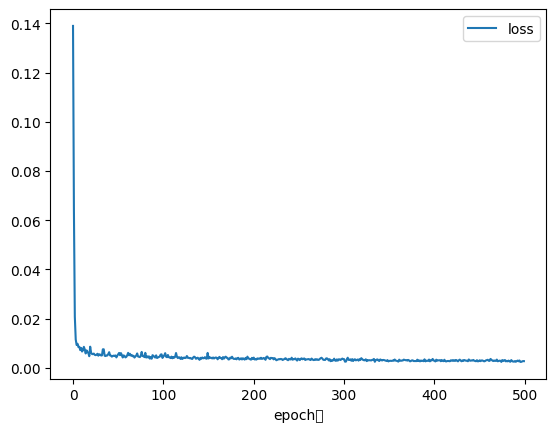

In [12]:
# トレーニング過程での損失を可視化
plt.plot(history1.epoch, history1.history["loss"], label="loss")
plt.xlabel("epoch数")
plt.legend()

## 2.3. モデルのテスト・評価
---
- **解説**
    - 2.2.にて学習させたモデルに対してテストデータを適用させてモデルの精度を検証する。

In [13]:
# モデルに検証データを代入して予測を行う
train_pred = model1.predict({"Close": X1_test})

2/2 [==============================] - 0s 8ms/step


- **解説**
    - 1.にて、あらかじめデータを正規化していたため、値を元に戻す動作が必要となる。
    - 次元を削除して演算可能な状態に戻し、正規化していた予測値と実測値の値を元のスケールに戻す。

In [14]:
# 次元の削減
train_pred = np.squeeze(train_pred)

# 予測値と実際の値を元のスケールに変換
train_pred = scaler_X.inverse_transform(train_pred.reshape(-1, 1))
y_train_orig = scaler_X.inverse_transform(y1_test.reshape(-1, 1))

- **解説**
    - モデルを評価する評価指標として、MAE, MSE, RMSE, MAPEを採用した。
    - 今回はモデルの比較のため、なるべく多くの評価指標で検討する必要がある。

In [15]:
# 評価指標による精度の評価
# 平均絶対誤差 (MAE)
mae = mean_absolute_error(y_train_orig, train_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 平均二乗誤差 (MSE)
mse = mean_squared_error(y_train_orig, train_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 平方根平均二乗誤差 (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 平均絶対パーセンテージ誤差 (MAPE)
mape = np.mean(np.abs((y_train_orig - train_pred) / y_train_orig)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 48.154304492187514
Mean Squared Error (MSE): 3146.8901566886443
Root Mean Squared Error (RMSE): 56.09714927417118
Mean Absolute Percentage Error (MAPE): 1.103589172144136


- **解説**
    - 実測値がActual、予測値がPredictedと指定し、結果がわかりやすいようにデータフレームでまとめる。
    - データフレームを元にグラフを描画し、実測値と予測値の時系列的な推移を確認する。

In [16]:
# 正解データと予測値をまとめる
results_df = pd.DataFrame({'Actual': y_train_orig.flatten(), 'Predicted': train_pred.flatten()})
results_df

,Actual,Predicted
0,4119.17,4097.288086
1,4137.64,4083.605225
2,4130.62,4100.495117
3,4124.08,4097.431641
4,4136.28,4095.146240
5,4109.90,4108.200684
6,4158.77,4089.922119
7,4198.05,4132.283203
8,4191.98,4165.720703
9,4192.63,4162.542480


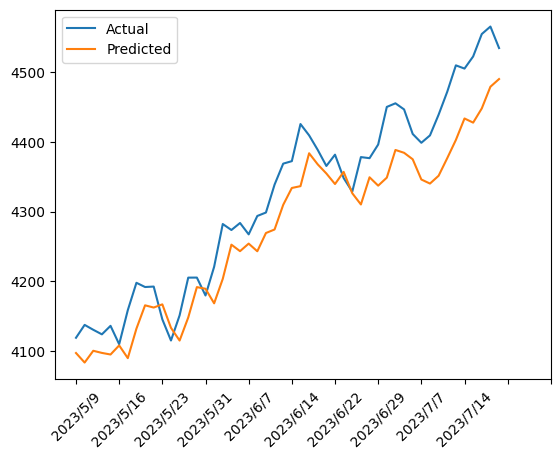

In [17]:
# テスト期間の日付を抽出
test_date_df  = df["Date"][len(X1_train) + windows_size:len(X1_train) + windows_size+len(X1_test)]

# x軸・y軸の定義
x = test_date_df
y1 = results_df["Actual"]
y2 = results_df["Predicted"]

# グラフの描画
plt.plot(x, y1, label='Actual')
plt.plot(x, y2, label='Predicted')

plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], rotation=45)
plt.legend()


# **3. モデル２：S&P500の株価データとS&P500ツイッター・センチメント指数で学習させたパターン**
---
- **解説**
    - このモデルは、S&P500の株価データとS&P500ツイッター・センチメント指数で学習させたパターンのモデルで、モデルの構築から学習、テストまでの一連の予測分析を行う。
    - モデル２の予測分析後、モデル１の予測精度と比較し、考察を行なっていく。

## 3.1. モデルの構築
---
- **解説**
    - 入力されたS&P500のデータとS&P500ツイッター・センチメント指数はそれぞれ別の入力層を通過すると、LSTM層を通過する。その後、連結層にて二つのデータの連結を行い、全結合層、Dropout層を経て出力層にて予測値が出力される。
- **モデル構造**
    - 入力層
    - LSTM層
        - 隠れ層にて時系列的なデータを受け継ぐ。
        - 128層、活性化関数はtanh
    - 連結層
        - モデル２の比較用に残した。
    - 全結合層
        - 128層、活性化関数はrelu関数
    - Dropout層
        - 程よく不活性化させることで過学習を防ぐ。
        - Dropout率25%
    - 出力層
        - 今回は線形分析のため、linerを指定。
- **モデルコンパイル**
    - 最適化アルゴリズムはnadam、損失関数はmse（平均二乗誤差）を最小した。

In [18]:
def build_model2(windows_size):
    """
    Build a LSTM model for time series prediction.

    Args:
        length_of_days (int): The number of days to consider for the time series prediction.

    Returns:
        model (tensorflow.keras.Model): A compiled LSTM model ready for training.
    """

    # 入力層
    input_a = Input(shape=(windows_size, 1), name="Close")
    input_b = Input(shape=(windows_size, 1), name="Sentiment")

    # LSTM層
    encoded_a = layers.LSTM(128, activation='tanh', return_sequences=False, name="LSTM_Close")(input_a)
    encoded_b = layers.LSTM(128, activation='tanh', return_sequences=False, name="LSTM_Sentiment")(input_b)

    # 連結層
    x = layers.concatenate([encoded_a , encoded_b], axis=-1, name="Concatenate_Close_Sentiment")

    # 全結合層
    x = layers.Dense(128, activation='relu', name="dense_all")(x)
    
    # Dropout層
    x = layers.Dropout(0.25, name="Dropout_0.25_Close")(x)

    # 出力層
    output = layers.Dense(1, activation='linear', name="Predict_Close")(x)

    # モデルのコンパイル
    model = Model([input_a, input_b], output)
    model.compile(optimizer='nadam', loss='mean_squared_error')

    return model

In [19]:
# モデルの指定
model2 = build_model2(windows_size)

# モデル構造の書き出し
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Close (InputLayer)             [(None, 40, 1)]      0           []                               
                                                                                                  
 Sentiment (InputLayer)         [(None, 40, 1)]      0           []                               
                                                                                                  
 LSTM_Close (LSTM)              (None, 128)          66560       ['Close[0][0]']                  
                                                                                                  
 LSTM_Sentiment (LSTM)          (None, 128)          66560       ['Sentiment[0][0]']              
                                                                                            

## 3.2. モデルの学習
---
- **解説**
    - 3.1.で構築したモデルを使用し、epoch数500、バッチサイズ128として学習を回す。

In [20]:
# epoch数の指定
epochs = 500

# モデルのトレーニング
history2 = model2.fit({"Close": X1_train, "Sentiment": X2_train},
                     {"Predict_Close": y1_train},
                     batch_size=128,
                     epochs=epochs)

Epoch 1/500
2/2 [==============================] - 2s 24ms/step - loss: 0.1470
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0384
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0123
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0120
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0118
Epoch 6/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0103
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0084
Epoch 8/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0112
Epoch 9/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0131
Epoch 10/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0090
Epoch 11/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0096
Epoch 12/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0091
Epoch 13/500
2/2 [==============================]

- **解説**
    - 損失lossの推移をグラフに描画した。
    - epoch数が上昇すると一気にlossが下がり、以降は停滞していることがわかる。
    - 上記のようなグラフになると、一応学習は行えている状況である。なお、lossの低下が見られない場合や停滞区域が極端に長い場合にはepoch数を見直す必要がある。

/home/sakulab/anaconda3/envs/yasudaSPP/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/home/sakulab/anaconda3/envs/yasudaSPP/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


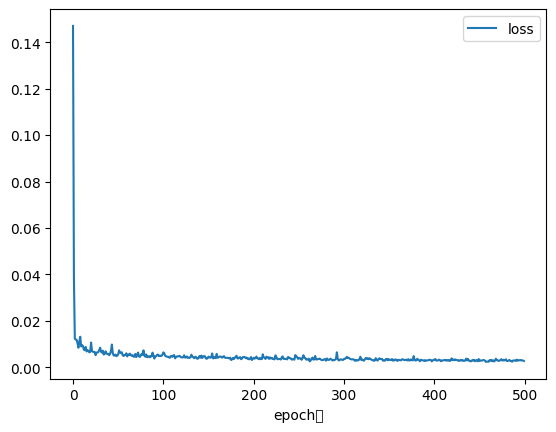

In [21]:
# トレーニング過程での損失を可視化
plt.plot(history2.epoch, history2.history["loss"], label="loss")
plt.xlabel("epoch数")
plt.legend()

## 3.3. モデルのテスト・評価
---
- **解説**
    - 3.2.にて学習させたモデルに対してテストデータを適用させ、モデルの精度を検証する。

In [22]:
# モデルに検証データを代入して予測を行う
train_pred = model2.predict({"Close": X1_test, "Sentiment": X2_test},)

2/2 [==============================] - 1s 9ms/step


- **解説**
    - 1.にて、あらかじめデータを正規化していたため、値を元に戻す動作が必要となる。
    - 次元を削除して演算可能な状態に戻し、正規化していた予測値と実測値の値を元のスケールに戻す。

In [23]:
# 次元の削減
train_pred = np.squeeze(train_pred)

# 予測値と実際の値を元のスケールに変換
train_pred = scaler_X.inverse_transform(train_pred.reshape(-1, 1))
y_train_orig = scaler_X.inverse_transform(y1_test.reshape(-1, 1))

- **解説**
    - モデルを評価する評価指標として、MAE, MSE, RMSE, MAPEを採用した。
    - 今回はモデルの比較のため、なるべく多くの評価指標で検討する必要がある。

In [24]:
# 評価指標による精度の評価
# 平均絶対誤差 (MAE)
mae = mean_absolute_error(y_train_orig, train_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 平均二乗誤差 (MSE)
mse = mean_squared_error(y_train_orig, train_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 平方根平均二乗誤差 (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 平均絶対パーセンテージ誤差 (MAPE)
mape = np.mean(np.abs((y_train_orig - train_pred) / y_train_orig)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 30.059723046875042
Mean Squared Error (MSE): 1345.1517848901776
Root Mean Squared Error (RMSE): 36.676310949851235
Mean Absolute Percentage Error (MAPE): 0.690978886792207


- **解説**
    - 実測値がActual、予測値がPredictedと指定し、結果がわかりやすいようにデータフレームでまとめる。
    - データフレームを元にグラフを描画し、実測値と予測値の時系列的な推移を確認する。

In [25]:
# 正解データと予測値をまとめる
results_df = pd.DataFrame({'Actual': y_train_orig.flatten(), 'Predicted': train_pred.flatten()})
results_df

,Actual,Predicted
0,4119.17,4122.400391
1,4137.64,4106.245117
2,4130.62,4118.985352
3,4124.08,4114.175293
4,4136.28,4113.510254
5,4109.90,4125.909180
6,4158.77,4106.157715
7,4198.05,4146.802246
8,4191.98,4180.854004
9,4192.63,4182.622559


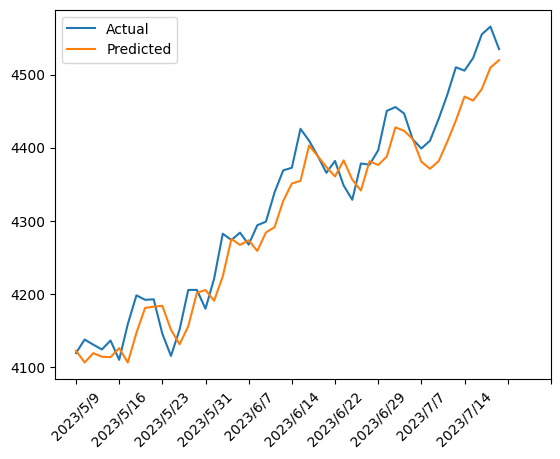

In [26]:
# テスト期間の日付を抽出
test_date_df  = df["Date"][len(X1_train) + windows_size:len(X1_train) + windows_size + len(X1_test)]

# x軸・y軸の定義
x = test_date_df
y1 = results_df["Actual"]
y2 = results_df["Predicted"]

# グラフの描画
plt.plot(x, y1, label='Actual')
plt.plot(x, y2, label='Predicted')

plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], rotation=45)
plt.legend()
